# Importing Packages

In [1]:
from pyblock2.driver.core import DMRGDriver, SymmetryTypes, MPOAlgorithmTypes
import numpy as np
import math
import matplotlib.pyplot as plt
import time

# Functions for Constructing Matrices

In [2]:
def vector_to_hermitian(upper_triangle_vector):
    # Check if the input vector is real-valued or complex-valued
    is_real = np.isrealobj(upper_triangle_vector)
    
    # Determine the size of the matrix (n x n)
    n = int(np.sqrt(2 * len(upper_triangle_vector) + 0.25) - 0.5)
    
    # Initialize an empty matrix with the appropriate type
    dtype = float if is_real else complex
    A = np.zeros((n, n), dtype=dtype)
    
    # Fill in the upper triangle
    indices = np.triu_indices(n)
    A[indices] = upper_triangle_vector
    
    # Assign values to the lower triangle
    i_lower = np.tril_indices(n, -1)
    if is_real:
        A[i_lower] = A.T[i_lower]  # Copy upper triangle values to lower triangle
    else:
        A[i_lower] = np.conj(A.T[i_lower])  # Assign conjugate transpose to lower triangle
    
    return A

# Definitions

In [3]:
params = {}
params['L'], params['N'], params['nmax'] = 64, 64, 4
params['L1'], params['L2'], params['L3'] = 30, 34, 64 
params['t'], params['U1'], params['U2'], params['U3'] = 1.0, 0.5, 10.0, 0.5

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SAny, n_threads=4)

driver.set_symmetry_groups("U1")
Q = driver.bw.SX

In [4]:
# [Part A] Set states and matrix representation of operators in local Hilbert space
site_basis, site_ops = [], []

# Definig Operators
bdag = np.diag(np.sqrt(np.arange(1, params['nmax'] + 1)), k=-1) # b+
b = bdag.T # b
n = np.diag(np.arange(0, params['nmax'] + 1), k=0) # particle number 
parity = np.diag([(-1.)**n for n in range(params['nmax']+1)]) # Parity no.

for k in range(params['L']):
    basis = [(Q(i), 1) for i in range(params['nmax'] + 1)] 
    ops = {
        "": np.identity(params['nmax'] + 1), # identity
        "C": bdag, # b+
        "D": b,  # b
        "N": n, # particle number
        "P": parity, # Parity no.
    }
    site_basis.append(basis)
    site_ops.append(ops)

# Setting Up Hamiltonian

In [5]:
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()


for i in range(params['L']-1):
    b.add_term("CD", [i, i+1], -params['t'])
    b.add_term("CD", [i+1, i], -params['t'])

# Region 1 
for i in range(0, params['L2'], 1):
    b.add_term("CCDD", [i, i, i, i], params['U1'] / 2)
    b.add_term("CD", [i, i], - params['U1'] / 2)

# Region 2
for i in range(params['L1'], params['L2'], 1):
    b.add_term("CCDD", [i, i, i, i], params['U2'] / 2)
    b.add_term("CD", [i, i], - params['U2'] / 2)

# Region 3
for i in range(params['L2'], params['L3'], 1):
    b.add_term("CCDD", [i, i, i, i], params['U3'] / 2)
    b.add_term("CD", [i, i], - params['U3'] / 2)

In [6]:
# [Part C] Perform DMRG

start_time = time.time()
#########################################

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)

mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=1, occs=[1] * params['L'])
energy = driver.dmrg(
    mpo, 
    mps, 
    n_sweeps=100, 
    bond_dims=[50] * 10 + [100] * 5 + [200] * 5 + [500] * 5 + [1000] * 5, 
    noises=[1e-3] * 3 + [1e-5] * 3 + [0],  
    thrds=[1e-10] * 20, 
    dav_max_iter=100, 
    tol=1e-10, 
    iprint=1)
print("Final bond dimension =", mps.info.get_max_bond_dimension())

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")



Sweep =    0 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      0.412 | E =    -142.4360162751 | DW = 2.86528e-11

Sweep =    1 | Direction = backward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      1.643 | E =    -143.1317414449 | DE = -6.96e-01 | DW = 6.23368e-08

Sweep =    2 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      3.221 | E =    -143.3306654892 | DE = -1.99e-01 | DW = 2.94408e-07

Sweep =    3 | Direction = backward | Bond dimension =   50 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      4.349 | E =    -143.4322424847 | DE = -1.02e-01 | DW = 1.46592e-07

Sweep =    4 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      5.710 | E =    -143.4876835338 | DE = -5.54e-02 | DW = 2.62514e-07

Sweep =    5 | Direction = backward 

In [7]:
# kets = [driver.split_mps(mps, ir, tag="KET-%d" % ir) for ir in range(mps.nroots)]

## <font color='blue'>Current Measurement</font>

### <font color='black'>Constructing MPO for $(-1)^{\hat{N}_{R_{1}}}$ where $\hat{N}_{R_{1}} = \sum_{i \in R_{1}} n_{i}$</font>

In [8]:
b_n = driver.expr_builder()
Parity_L1 = "P" * params['L1'] 
lst_index_L1 = list(range(params['L1']))
# b_n.add_term(Parity_L1, lst_index_L1, 1)
b_n.add_term('PPPPPPPPPPPPPPPPPPPPPPPPPPPPPP',[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29], 1)
N1_op = driver.get_mpo(b_n.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite, iprint = 1)


Build MPO | Nsites =    64 | Nterms =          1 | Algorithm = FastBIP | Cutoff = 1.00e-14
 Site =     0 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.001
 Site =     1 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.000
 Site =     2 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.000
 Site =     3 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.000
 Site =     4 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.000
 Site =     5 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.001
 Site =     6 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.000
 Site =     7 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc = 0.000 T = 0.000
 Site =     8 /    64 .. Mmpo =     1 DW = 0.00e+00 NNZ =        1 SPT = 0.0000 Tmvc

### <font color='black'>Applying $\ket{\psi^{\prime}} = (-1)^{\hat{N}_{R_{1}}}\ket{\psi}$</font>

In [26]:
# bra = driver.get_random_mps(tag="BRA_N1_op", bond_dim=1000, nroots=1, occs=[1] * params['L'])
bra = driver.get_random_mps(tag="BRA_N1_op", bond_dim=1000, nroots=1, center=mps.center)
bra = driver.copy_mps(mps,"NewKet")
driver.multiply(bra, N1_op, mps, n_sweeps=10, bond_dims=[1000], thrds=[1E-10] * 10, iprint=1)


Sweep =    0 | Direction =  forward | BRA bond dimension = 1000 | Noise =  0.00e+00
Time elapsed =      7.311 | F =    0.1794720588 | DW = 4.72217e-19

Sweep =    1 | Direction = backward | BRA bond dimension = 1000 | Noise =  0.00e+00
Time elapsed =     14.574 | F =    1.0000000000 | DF = 8.21e-01 | DW = 1.74715e-18

Sweep =    2 | Direction =  forward | BRA bond dimension = 1000 | Noise =  0.00e+00
Time elapsed =     21.874 | F =    1.0000000000 | DF = 2.44e-15 | DW = 4.21808e-19

Sweep =    3 | Direction = backward | BRA bond dimension = 1000 | Noise =  0.00e+00
Time elapsed =     29.170 | F =    1.0000000000 | DF = 1.78e-15 | DW = 2.42448e-18

Sweep =    4 | Direction =  forward | BRA bond dimension = 1000 | Noise =  0.00e+00
Time elapsed =     36.548 | F =    1.0000000000 | DF = 1.55e-15 | DW = 3.36006e-19



1.0000000000000384

#### <font color='blue'>Single-particle boson correlations</font>

##### Calculate

In [37]:
start_time = time.time()

bosoncorr_mat = driver.get_npdm(bra, npdm_expr='CD', fermionic_ops='', mask=[0, 1])[0]
navg = np.diag(bosoncorr_mat)
print("Total number =", sum(navg))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Total number = 64.00000000000458
Elapsed time: 10.14747428894043 seconds


##### Site occupations

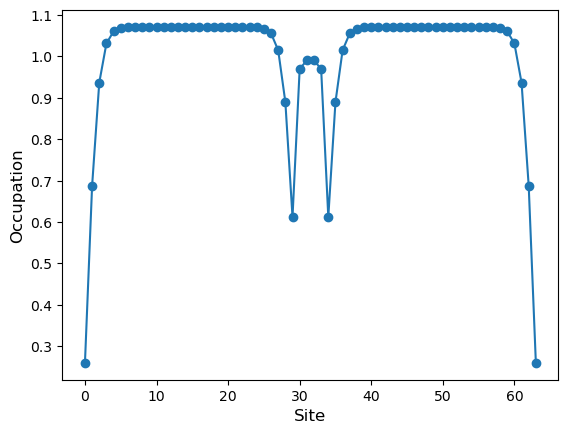

In [38]:
plt.plot(np.arange(params['L']), navg, marker='o')
plt.xlabel('Site', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.show()

##### Correlation matrix

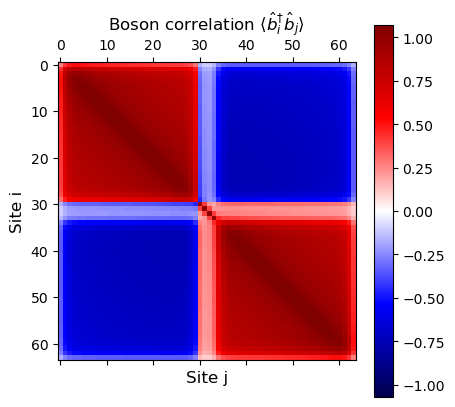

In [39]:
plt.matshow(bosoncorr_mat, cmap='seismic', vmin=-np.abs(bosoncorr_mat).max(), vmax=np.abs(bosoncorr_mat).max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Boson correlation $\langle \hat{b}_{i}^{\dagger} \hat{b}_{j} \rangle$')
plt.show()

##### Correlation vs distance

In [ ]:
plt.plot(np.arange(1,params['L']//2+1), bosoncorr_mat[params['L']//2-1,params['L']//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $\langle \hat{b}_{L/2}^{\dagger} \hat{b}_{L/2+r} \rangle$', fontsize=12)
plt.yscale('log')
plt.xscale('linear')
plt.show()

### <font color='black'>Time Evolution of $\ket{\psi^{\prime}}$:: $\ket{\psi(t)} = e^{-i\cdot t \cdot H_{AJJ}}\ket{\psi^{\prime}}$</font>

In [11]:
mps3 = driver.td_dmrg(mpo = mpo, ket = mps2, delta_t=0.1 * 1j, target_t = 1 * 1j, final_mps_tag="mps3", bond_dims = [700], hermitian=True, iprint = 1)

Time Evolution  DELTA T = RE      0.00000000 + IM      0.10000000
Time Evolution TARGET T = RE      0.00000000 + IM      1.00000000
Time Evolution   NSTEPS =         10


AttributeError: 'float' object has no attribute 'deep_copy'

In [ ]:
# mps3 = driver.td_dmrg(mpo, mps2, delta_t=0.1, target_t=1, final_mps_tag="KET_TimeEvolveHAJJ")

## <font color='blue'>Evolution over sweeps</font>

In [ ]:
bonddims, discardedweights, energies = driver.get_dmrg_results()
plt.plot(energies.flatten(), marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Energy', fontsize=12)
plt.show()
plt.plot(bonddims, marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Bond dimension', fontsize=12)
plt.show()
plt.plot(discardedweights, marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Discarded weight', fontsize=12)
plt.yscale('log')
plt.show()

## <font color='blue'>Entanglement</font>

In [ ]:
SvN = driver.get_bipartite_entanglement()

plt.plot(np.arange(1,params['L']), SvN, marker='o')
plt.xlabel('Bond', fontsize=12)
plt.ylabel('Entanglement entropy', fontsize=12)
plt.show()

## <font color='blue'>Single-particle boson correlations</font>

### Calculate

In [ ]:
start_time = time.time()

bosoncorr_mat = driver.get_npdm(mps, npdm_expr='CD', fermionic_ops='', mask=[0, 1])[0]
navg = np.diag(bosoncorr_mat)
print("Total number =", sum(navg))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

### Site occupations

In [ ]:
plt.plot(np.arange(params['L']), navg, marker='o')
plt.xlabel('Site', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.show()

### Correlation matrix

In [ ]:
plt.matshow(bosoncorr_mat, cmap='viridis', vmin=bosoncorr_mat.min(), vmax=bosoncorr_mat.max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Boson correlation $\langle \hat{b}_{i}^{\dagger} \hat{b}_{j} \rangle$')
plt.show()

### Correlation vs distance

In [ ]:
plt.plot(np.arange(1,params['L']//2+1), bosoncorr_mat[params['L']//2-1,params['L']//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $\langle \hat{b}_{L/2}^{\dagger} \hat{b}_{L/2+r} \rangle$', fontsize=12)
plt.yscale('log')
plt.xscale('linear')
plt.show()

## <font color='blue'>On-site number distribution</font>

### Calculate

In [ ]:
start_time = time.time()

ndist = np.array(driver.get_npdm(mps, npdm_expr=proj_keys, fermionic_ops='')).T
print("Deviation from unit filling =", np.linalg.norm([ndist[i].sum()-1 for i in range(params['L'])]))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

### Site-averaged number distribution

In [ ]:
plt.plot(np.mean(ndist, axis=0), marker='o')
plt.xlabel('$n$', fontsize=12)
plt.ylabel('Site-avgd distribution $p(n)$', fontsize=12)
plt.yscale('linear')
plt.show()

### Number fluctuation

In [ ]:
nsqavg = np.array([np.dot(np.arange(params['nmax']+1)**2, ndist[i]) for i in range(params['L'])])
numfluc = np.sqrt(nsqavg - navg*navg)
plt.plot(np.arange(params['L']), numfluc, marker='o')
plt.xlabel('Site', fontsize=12)
plt.ylabel('Number fluctuation', fontsize=12)
plt.title(f"Avg = {np.mean(numfluc)}")
plt.show()

### Calculate

In [ ]:
start_time = time.time()

nnexp_mat = driver.get_npdm(mps, npdm_expr='CDCD', fermionic_ops='', mask=[0, 0, 1, 1])[0]
densitycorr_mat = nnexp_mat - np.outer(navg, navg)
print("Avg number fluctuation =", np.mean(np.sqrt(np.diag(densitycorr_mat))))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

### Correlation matrix

In [ ]:
plt.matshow(densitycorr_mat, cmap='seismic', vmin=-np.abs(densitycorr_mat).max(), vmax=np.abs(densitycorr_mat).max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Density correlation $\langle \hat{n}_{i}, \hat{n}_{j} \rangle$')
plt.show()

### Correlation vs distance

In [ ]:
plt.plot(np.arange(1,params['L']//2+1), -densitycorr_mat[params['L']//2-1,params['L']//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $-\langle \hat{n}_{L/2}, \hat{n}_{L/2+r} \rangle$', fontsize=12)
plt.yscale('log')
plt.xscale('linear')
plt.show()